In [1]:
# uploading the libraries will be using
import torch
from torch.utils.data import Dataset
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler

In [231]:
class Parabola(Dataset): # class Dataset() to generate our data/dataset that will be fed into our model
    def __init__(self,train,length): # initializer to generate train/validate data, with number of samples as length
        # generating weights randomly which are coefficients in the polynomial y = w1.x^2 + w2.x + c
        w1 = random.random()
        w2 = random.random()
        
        self.x = np.random.uniform(low = -10, high = 10, size=length) # independent variable
        if train == True:
            self.x = self.x[0:200] #samples in training data
            self.b0 = np.random.normal(-11,11,int(length*.80)).reshape(-1,1) # adding gaussian noise 
        elif train == False:
            self.x = self.x[200::] # samples in validation data
            self.b0 = np.random.normal(-12,12,int(length*.20)).reshape(-1,1)
        # regression model in pytorch assumes y = f(x) as y = mx + c, hence we convert our quadratic polynomial to this form                                          
        self.z = self.x**2 # y = w1.z + w2.x + c 
        self.X = np.vstack((self.z,self.x)).T # X = [z,x] with dimensions lengthx2, length rows & 2 columns
        self.W = np.asarray([w1,w2]).reshape((2,1)) # W will have dimensions 2x1, 2 rows and 1 column to obtain a dot product with X
        self.y = np.dot(self.X,self.W) + self.b0 # y = X.W + B, where y has dimensions lengthx1
        
        self.len = length
       
    def __getitem__(self,index): # to fetech our X samples and its corresponding y samples 
        points = torch.tensor(self.X, dtype = torch.float32), torch.tensor(self.y, dtype = torch.float32)
        return points # this will be a tuple
    
    def __len__(self):
        return self.len

In [232]:
#obtaining our training and validation datasets
samples_train = Parabola(True,250) # train is True and length is the number of samples I want 
samples_val = Parabola(False,250) # train is false to obtain validation samples
len(samples_train.x), len(samples_val.x)

(200, 50)

Equation of the parabola is :
0.7239204603230528.x^2 + 0.640909040474428.x + c


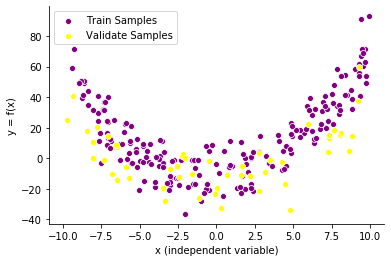

In [233]:
# Visualizing our data 
import seaborn as sns
fig_train = sns.scatterplot(samples_train.x.flatten(),samples_train.y.flatten(),label = 'Train Samples', color='purple')
sns.scatterplot(samples_val.x.flatten(),samples_val.y.flatten(), label = 'Validate Samples',color = 'yellow')
fig_train.set(xlabel = 'x (independent variable)', ylabel = 'y = f(x)')
sns.despine()
print('Equation of the parabola is :')
print('{}.x^2 + {}.x + c'.format(samples_train.W[0][0],samples_train.W[1][0]))

In [234]:
# definiing our polynomial regression model
import torch.nn as nn # the nn module contain the Linear Regression class

class PolyRegression(nn.Module):
    def __init__(self,input_size,output_size):
        # For Linear Regression input size is 1 and output size is 1 as : in y = m.x + c there is only one..
        #independent variable(dimension) x and for each value of x there will be one value of y
        super(PolyRegression,self).__init__()
        self.poly = nn.Linear(input_size,output_size) 
        # polynomial regression will have the degree of the polynomial as the input size since we..
        #are treating each degree as an independent variable, separate dimension
    def forward(self,x):
        out = self.poly(x)
        return out
    
model_poly = PolyRegression(2,1).cuda() # inputs would be [x^2,x], x^2 is defined by z in the dataset class
#for polynomial of degree n, inputs would be [x^n,x^n-1,....,x] and weights would be a column vector of dimension nx1 : [w1,w2....,wn]

print('initialized w1 = {}'.format(model_poly.state_dict()['poly.weight'][0][0]),
      ',initialized w2 = {}'.format(model_poly.state_dict()['poly.weight'][0][1]))
print('initialized bias = {}'.format(model_poly.state_dict()['poly.bias'][0]))

initialized w1 = -0.6327937841415405 ,initialized w2 = 0.3680242896080017
initialized bias = -0.5631729364395142


In [235]:
# initializing the dataloader to get batches of data
from torch.utils.data import DataLoader
#DataLoader(dataset,batch_size,shuffle), arguments dataset = samples_train which is the training data..
#batch_size = 50 and shuffle = True
train_loader = DataLoader(samples_train,50,True) #this will present the data to our model in batches of 50 samples

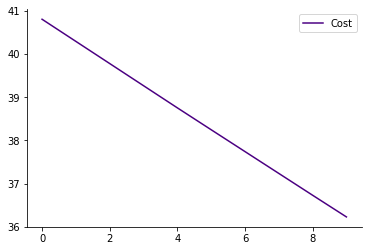

In [236]:
# defining a function that trains our regression model
from torch import optim

def train_model(epochs,model,dataset, learning_rate):
    criterion = nn.L1Loss() # Mean Absolute Error
    cost = []
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    for epoch in range(epochs):
        for x,y in dataset:
            yhat = model(x.to('cuda'))
            loss = criterion(yhat,y.to('cuda')) # loss is |yhat - y|^2 averaged over number of samples
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        cost.append(loss.detach().to('cpu').item())
    return model,yhat,cost

predictions = train_model(10,model_poly,train_loader,0.0001) #testing the train_model function
sns.lineplot(np.asarray(range(0,len(predictions[2]))),np.asarray(predictions[2]).flatten(),
             label = 'Cost',color='indigo', legend='full')
sns.despine()

In [237]:
# defining a function that evaluates our trained regression model
def evaluate_model(model,x_data,y_data):
    criterion = nn.L1Loss()
    y_predicted = model(torch.tensor(x_data, dtype=torch.float32).to('cuda'))
    loss_predicted = criterion(y_predicted, torch.tensor(y_data, dtype = torch.float32).to('cuda'))
    error= loss_predicted.item()
    return error
# testing our evaluate model function
print('Model Error : {}\n'.format(evaluate_model(predictions[0],samples_val.X,samples_val.y)))

Model Error : 26.391578674316406



In [245]:
#hyperparameters
epochs = 2000
learning_rates = [0.000001,0.00001,0.0001,0.001,0.01,0.1]
validation_error = torch.zeros(len(learning_rates))
train_error = torch.zeros(len(learning_rates))
MODELS = []
COST =[]

In [246]:
for i,learning_rate in enumerate(learning_rates):
    model_poly = PolyRegression(2,1).cuda() #defining the model which initializes the weights and bias for each learning_rate
    predictions = train_model(epochs,model_poly,train_loader,learning_rate) # training our polynomial regression model with learning_rate
    COST.append(predictions[2])
    
    train_error[i] = evaluate_model(predictions[0],samples_train.X,y_data= samples_train.y)
    validation_error[i] = evaluate_model(predictions[0], samples_val.X, samples_val.y)
    
    MODELS.append(model_poly) #saves all the models for the different learning_rates
    
print('Model with lowest training error {}\n'.format(torch.argmin(train_error)+1),
      'Training Error : {}'.format(train_error[torch.argmin(train_error)]))
print('Model with lowest validation error {}\n'.format(torch.argmin(validation_error)+1),
      'Validation Error : {}'.format(train_error[torch.argmin(validation_error)]))

Model with lowest training error 5
 Training Error : 8.829649925231934
Model with lowest validation error 5
 Validation Error : 8.829649925231934


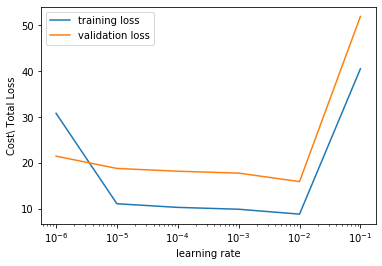

In [247]:
import matplotlib.pyplot as plt
plt.semilogx(np.array(learning_rates), train_error.numpy(), label = 'training loss')
plt.semilogx(np.array(learning_rates), validation_error.numpy(), label = 'validation loss')
plt.ylabel('Cost\ Total Loss')
plt.xlabel('learning rate')
plt.legend()
plt.show()

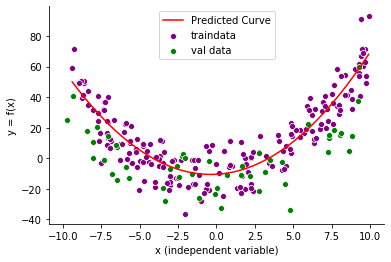

In [248]:
# visualizing the model with the lowest training error
predict = MODELS[torch.argmin(validation_error)](torch.tensor(samples_train.X, dtype = torch.float32).to('cuda'))
predict = predict.detach().to('cpu').numpy()
sns.scatterplot(samples_train.x.flatten(),samples_train.y.flatten(), color = 'purple', label = 'traindata')
sns.scatterplot(samples_val.x.flatten(),samples_val.y.flatten(), color = 'green', label = 'val data')
curve = sns.lineplot(samples_train.x.flatten(),predict.flatten(),label = 'Predicted Curve', color = 'red')
curve.set(xlabel = 'x (independent variable)', ylabel = 'y = f(x)')
sns.despine()

Text(0, 0.5, 'y = f(x)')

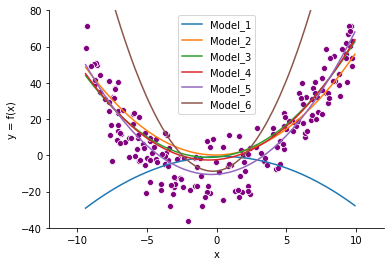

In [249]:
# visualizing all the MODELS
for i in range(len(MODELS)):
    predict = MODELS[i](torch.tensor(samples_train.X, dtype = torch.float32).to('cuda'))
    predict = predict.detach().to('cpu').numpy()
    sns.scatterplot(samples_train.x.flatten(),samples_train.y.flatten(), color = 'purple')
    sns.lineplot(samples_train.x.flatten(),predict.flatten(),label = 'Model_{}'.format(i+1))
    sns.despine()
plt.xlim(-12,12)
plt.ylim(-40,80)
plt.xlabel('x')
plt.ylabel('y = f(x)')